In [ ]:
from typing import Callable, Any
import glob
import json
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

DATASET = "adult"

In [ ]:
risan_pd = pd.DataFrame()
kp1_pd = pd.DataFrame()
dpabst_pd = pd.DataFrame()

if os.path.exists("risan.csv"):
    os.remove("risan.csv")
if os.path.exists("kp1.csv"):
    os.remove("kp1.csv")
if os.path.exists("dpabst.csv"):
    os.remove("dpabst.csv")

for file in glob.glob("results/*/*/*/*.json"):
    args = file.split("/")
    dataset = args[1]
    model = args[2]
    fairness_condition = args[3]
    cost_cov = args[4].split(".json")[0]

    record: dict[str, str | float] = {
        "dataset": dataset,
        "fairness_condition": fairness_condition,
    }
    if model != "dpabst":
        record["cost_0"] = cost_cov.split("_")[0]
        record["cost_1"] = cost_cov.split("_")[1]

    with open(file, "r") as f:
        data = json.load(f)
    for key in data:
        record[f"{key}"] = float(data[key][0])
        record[f"{key}_s"] = float(data[key][1])
    temp = pd.Series(record)
    temp = temp.to_frame().T

    if model == "risan":
        risan_pd = pd.concat([risan_pd, temp])
    elif model == "dpabst":
        dpabst_pd = pd.concat([dpabst_pd, temp])
    elif model == "kp1":
        kp1_pd = pd.concat([kp1_pd, temp])

for col in risan_pd.columns:
    if col == "dataset" or col == "fairness_condition":
        continue
    risan_pd[col] = round(risan_pd[col].astype(float), 2)

for col in kp1_pd.columns:
    if col == "dataset" or col == "fairness_condition":
        continue
    kp1_pd[col] = round(kp1_pd[col].astype(float), 2)

for col in dpabst_pd.columns:
    if col == "dataset" or col == "fairness_condition":
        continue
    dpabst_pd[col] = round(dpabst_pd[col].astype(float), 2)

risan_pd = risan_pd.sort_values(by="cov")
kp1_pd = kp1_pd.sort_values(by="cov")
dpabst_pd = dpabst_pd.sort_values(by="cov")

risan_pd.to_csv("risan.csv", index=False)
kp1_pd.to_csv("kp1.csv", index=False)
dpabst_pd.to_csv("dpabst.csv", index=False)

In [ ]:
risan_pd = risan_pd.loc[(risan_pd["dataset"] == DATASET)]
kp1_pd = kp1_pd.loc[(kp1_pd["dataset"] == DATASET)]
dpabst_pd = dpabst_pd.loc[(dpabst_pd["dataset"] == DATASET)]

In [ ]:
formatting = {
    "risan": {
        "color": "black",
        "linestyle": "-",
        "marker": ".",
        "label": "RISAN",
        "alpha": 0.4,
    },
    "risan g0": {
        "color": "black",
        "linestyle": "-",
        "marker": ".",
        "label": "RISAN group 0",
        "alpha": 0.4,
    },
    "risan g1": {
        "color": "black",
        "linestyle": "--",
        "marker": "x",
        "label": "RISAN group 1",
        "alpha": 0.4,
    },
    "eq risan": {
        "color": "blue",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE RISAN",
        "alpha": 0.4,
    },
    "eq risan g0": {
        "color": "blue",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE RISAN group 0",
        "alpha": 0.4,
    },
    "eq risan g1": {
        "color": "blue",
        "linestyle": "--",
        "marker": "x",
        "label": "EQUISCALE RISAN group 1",
        "alpha": 0.4,
    },

    "kp1": {
        "color": "red",
        "linestyle": "-",
        "marker": ".",
        "label": "KP1",
        "alpha": 0.4,
    },
    "kp1 g0": {
        "color": "red",
        "linestyle": "-",
        "marker": ".",
        "label": "KP1 group 0",
        "alpha": 0.4,
    },
    "kp1 g1": {
        "color": "red",
        "linestyle": "--",
        "marker": "x",
        "label": "KP1 group 1",
        "alpha": 0.4,
    },
    "eq kp1": {
        "color": "darkorange",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE KP1",
        "alpha": 0.4,
    },
    "eq kp1 g0": {
        "color": "darkorange",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE KP1 group 0",
        "alpha": 0.4,
    },
    "eq kp1 g1": {
        "color": "darkorange",
        "linestyle": "--",
        "marker": "x",
        "label": "EQUISCALE KP1 group 1",
        "alpha": 0.4,
    },

    "dpabst": {
        "color": "green",
        "linestyle": "-",
        "marker": ".",
        "label": "DPABST",
        "alpha": 0.4,
    },
    "eq dpabst g0": {
        "color": "green",
        "linestyle": "-",
        "marker": ".",
        "label": "DPABST group 0",
        "alpha": 0.4,
    },
    "eq dpabst g1": {
        "color": "green",
        "linestyle": "--",
        "marker": "x",
        "label": "DPABST group 1",
        "alpha": 0.4,
    },
}

In [ ]:
def plot_with_std(x_vals: pd.Series, y_vals: pd.Series, y_std: pd.Series, formatting):
    plot_kwargs = formatting.copy()
    del plot_kwargs["alpha"]
    fill_kwargs = formatting.copy()
    del fill_kwargs["label"]
    del fill_kwargs["marker"]
    plt.plot(x_vals, y_vals, **plot_kwargs)
    lower = ((y_vals - y_std).to_numpy()).clip(min=0, max=100)
    upper = ((y_vals + y_std).to_numpy()).clip(min=0, max=100)
    plt.fill_between(x_vals, lower, upper, **fill_kwargs)


def plot_without_std(x_vals, y_vals, formatting):
    plot_kwargs = formatting.copy()
    del plot_kwargs["alpha"]
    plt.plot(x_vals, y_vals, **plot_kwargs)

In [ ]:
def plots(dataframes: dict[str, pd.DataFrame], metric: str, std: bool, groupwise: bool, diff: bool):
    for key in dataframes:
        if std:
            if groupwise: # Individual model plots
                if key == "dpabst":
                    continue
                plot_with_std(
                    dataframes[key]["cov"],
                    dataframes[key][f"{metric}_0"],
                    dataframes[key][f"{metric}_0_s"],
                    formatting[f"{key} g0"],
                )
                plot_with_std(
                    dataframes[key]["cov"],
                    dataframes[key][f"{metric}_1"],
                    dataframes[key][f"{metric}_1_s"],
                    formatting[f"{key} g1"],
                )
            else: # Accuracy plots
                if key == "eq dpabst":
                    continue
                plot_with_std(
                    dataframes[key]["cov"],
                    dataframes[key][f"{metric}"],
                    dataframes[key][f"{metric}_s"],
                    formatting[f"{key}"],
                )
        else: # Difference plots
            if diff:
                if key == "eq dpabst":
                    continue
                plot_without_std(
                    dataframes[key]["cov"],
                    abs(dataframes[key][f"{metric}_0"] - dataframes[key][f"{metric}_1"]),
                    formatting[f"{key}"],
                )

In [ ]:
def print_table(
    dataframes: dict[str, pd.DataFrame], metrics: list[str], agr: Callable[[Any], Any]
):
    entries = {"model": []}
    for metric in metrics:
        entries[metric] = []
    for key in dataframes.keys():
        if key == "eq dpabst":
            continue
        entries["model"].append(key)
        for metric in metrics:
            entries[metric].append(
                np.round(
                    agr(
                        np.abs(
                            dataframes[key][f"{metric}_0"]
                            - dataframes[key][f"{metric}_1"]
                        )
                    ),
                    2,
                )
            )
    df = pd.DataFrame.from_dict(entries)
    print(df)

# Independence section

In [ ]:
risan_pd_none = risan_pd.loc[(risan_pd["fairness_condition"] == "none")]
kp1_pd_none = kp1_pd.loc[(kp1_pd["fairness_condition"] == "none")]

risan_pd_fair = risan_pd.loc[(risan_pd["fairness_condition"] == "ind")]
kp1_pd_fair = kp1_pd.loc[(kp1_pd["fairness_condition"] == "ind")]
dpabst_pd_fair = dpabst_pd.loc[(dpabst_pd["fairness_condition"] == "ind")]

if (
    not isinstance(risan_pd_none, pd.DataFrame)
    or not isinstance(risan_pd_fair, pd.DataFrame)
    or not isinstance(kp1_pd_none, pd.DataFrame)
    or not isinstance(kp1_pd_fair, pd.DataFrame)
    or not isinstance(dpabst_pd_fair, pd.DataFrame)
):
    exit()

dataframes: dict[str, pd.DataFrame] = {
    "risan": risan_pd_none,
    "eq risan": risan_pd_fair,
    "kp1": kp1_pd_none,
    "eq kp1": kp1_pd_fair,
    "dpabst": dpabst_pd_fair,
    "eq dpabst": dpabst_pd_fair,
}

In [ ]:
plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Accuracy vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Accuracy")
plt.grid(alpha=0.2)
plots(dataframes, "acc", True, False, False)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate difference vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
plots(dataframes, "pos", False, False, True)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate difference vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
plots(dataframes, "abs", False, False, True)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate difference vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
plots(dataframes, "neg", False, False, True)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for DPABST")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["eq dpabst"]}, "pos", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for DPABST")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["eq dpabst"]}, "abs", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for DPABST")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["eq dpabst"]}, "neg", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "pos", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "abs", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "neg", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "pos", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "abs", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "neg", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()

print("Average violation of fairness constraints")
print_table(dataframes, ["pos", "neg", "abs"], np.average)
print("Max violation of fairness constriants")
print_table(dataframes, ["pos", "neg", "abs"], np.max)
print("Min violation of fairness constraints")
print_table(dataframes, ["pos", "neg", "abs"], np.min)

# Separation section

In [ ]:
risan_pd_none = risan_pd.loc[(risan_pd["fairness_condition"] == "none")]
kp1_pd_none = kp1_pd.loc[(kp1_pd["fairness_condition"] == "none")]

risan_pd_fair = risan_pd.loc[(risan_pd["fairness_condition"] == "sep")]
kp1_pd_fair = kp1_pd.loc[(kp1_pd["fairness_condition"] == "sep")]

if (
    not isinstance(risan_pd_none, pd.DataFrame)
    or not isinstance(risan_pd_fair, pd.DataFrame)
    or not isinstance(kp1_pd_none, pd.DataFrame)
    or not isinstance(kp1_pd_fair, pd.DataFrame)
):
    exit()

dataframes: dict[str, pd.DataFrame] = {
    "risan": risan_pd_none,
    "eq risan": risan_pd_fair,
    "kp1": kp1_pd_none,
    "eq kp1": kp1_pd_fair,
}

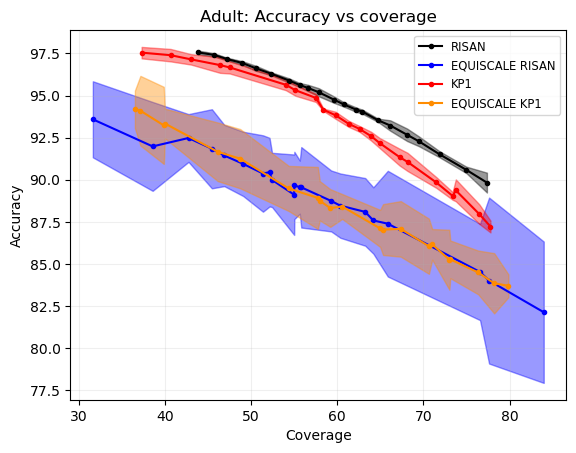

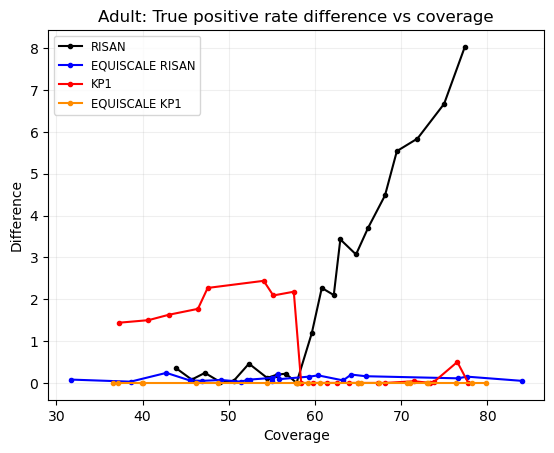

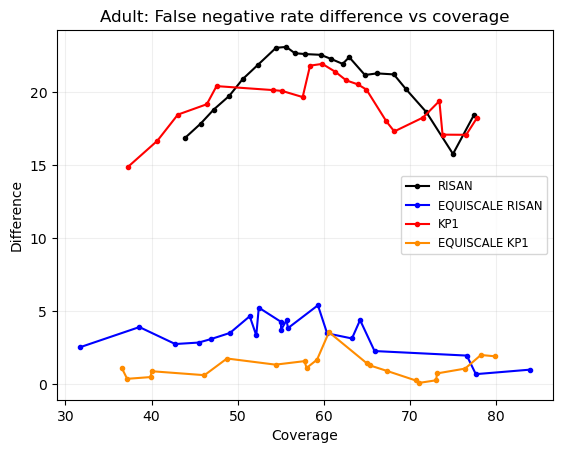

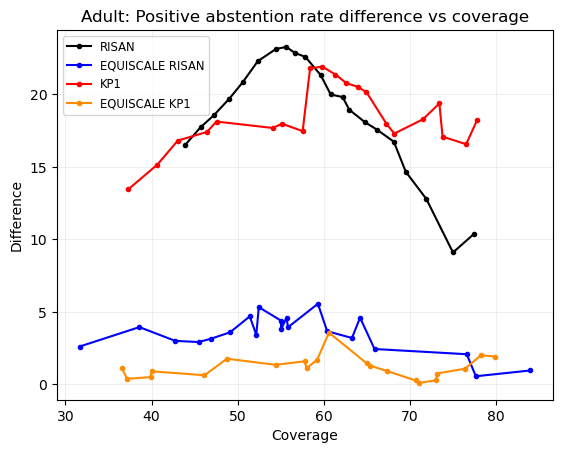

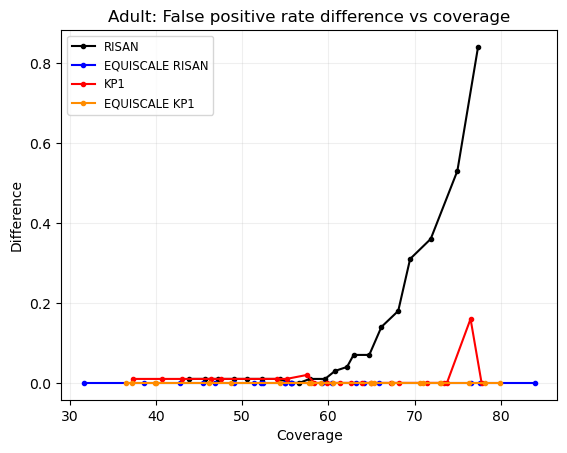

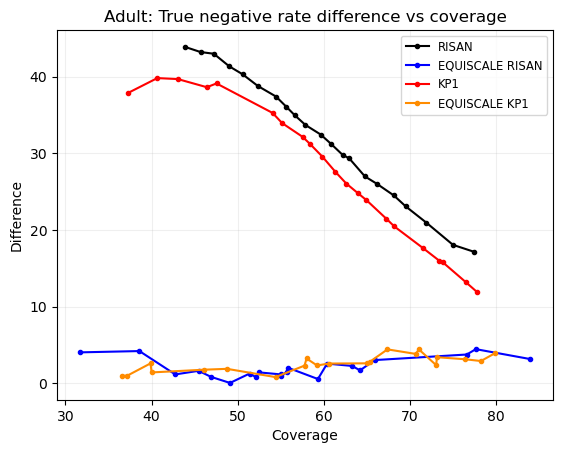

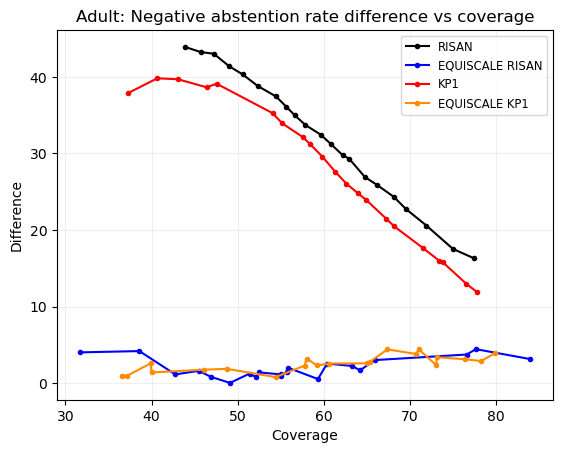

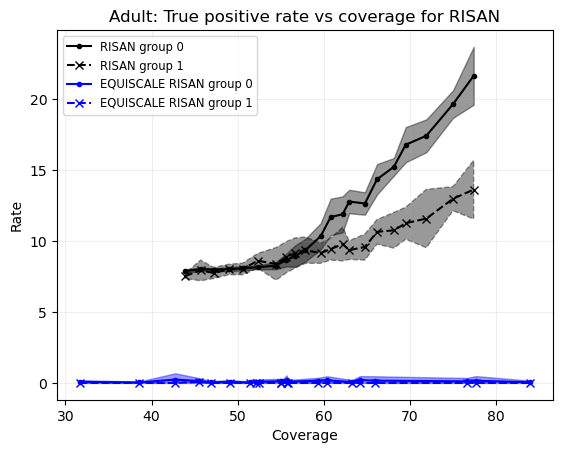

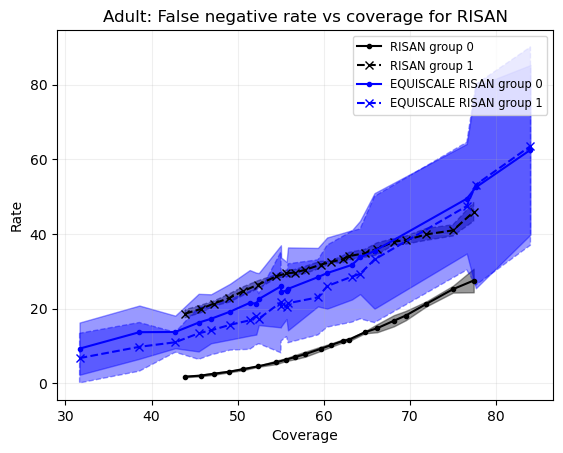

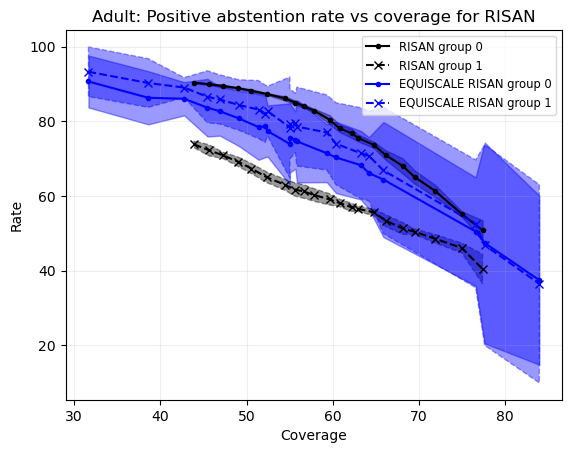

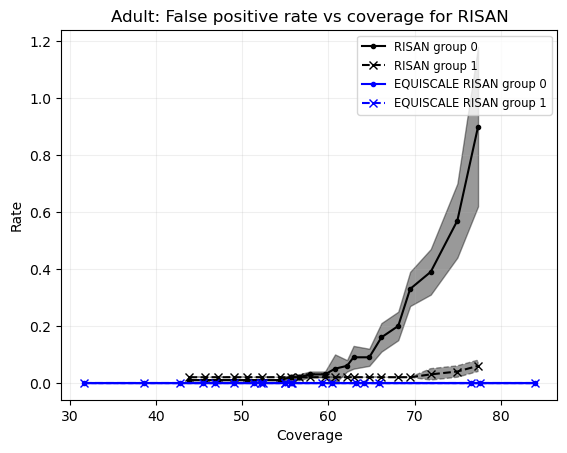

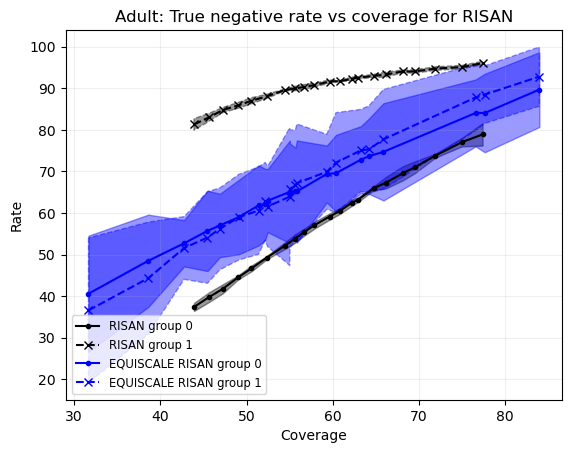

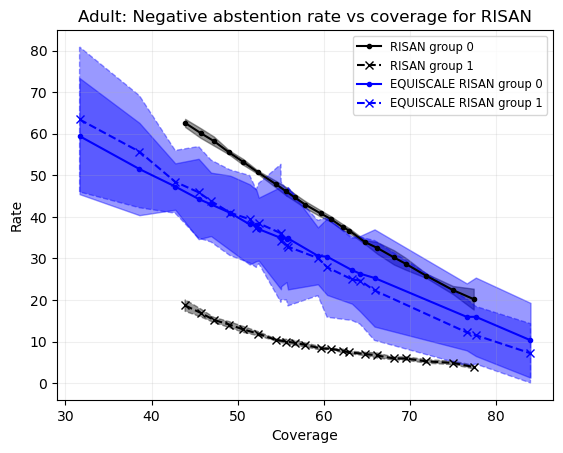

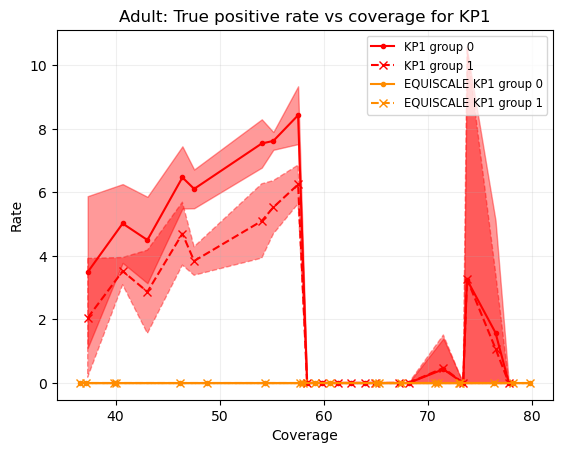

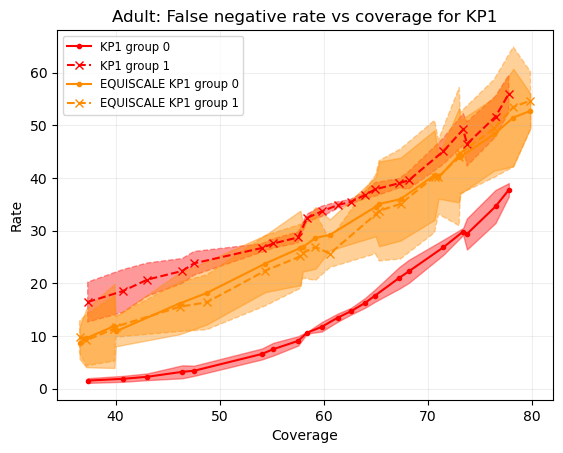

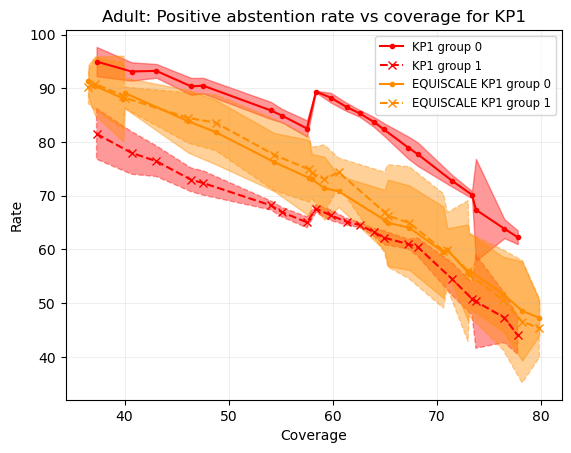

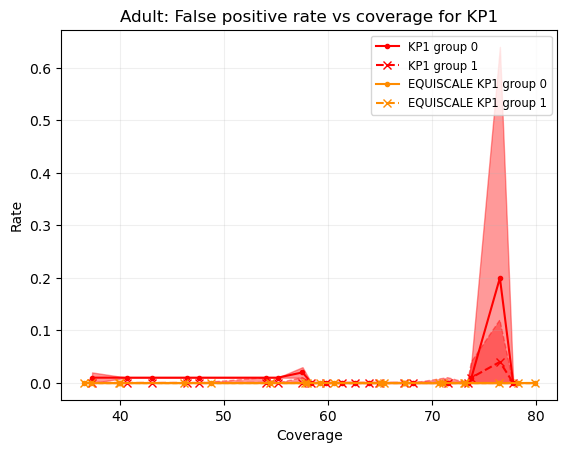

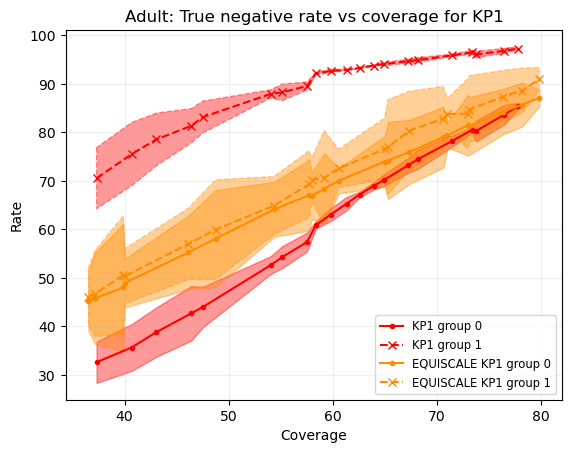

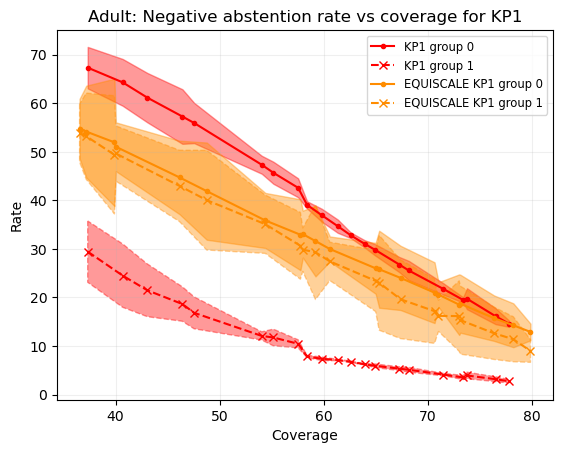

Average violation of fairness constraints
      model   tpr    fnr    par   fpr    tnr    nar
0     risan  2.29  20.62  18.43  0.13  32.02  31.90
1  eq risan  0.11   3.36   3.45  0.00   2.00   2.00
2       kp1  0.76  19.11  18.36  0.01  27.43  27.42
3    eq kp1  0.00   1.18   1.18  0.00   2.58   2.58
Max violation of fairness constriants
      model   tpr    fnr    par   fpr    tnr    nar
0     risan  8.03  23.08  23.28  0.84  43.90  43.91
1  eq risan  0.24   5.41   5.56  0.00   4.43   4.43
2       kp1  2.44  21.92  21.92  0.16  39.83  39.81
3    eq kp1  0.00   3.57   3.57  0.00   4.40   4.40
Min violation of fairness constraints
      model   tpr    fnr    par  fpr    tnr    nar
0     risan  0.00  15.76   9.10  0.0  17.16  16.32
1  eq risan  0.03   0.70   0.56  0.0   0.02   0.02
2       kp1  0.00  14.90  13.46  0.0  11.87  11.87
3    eq kp1  0.00   0.10   0.10  0.0   0.78   0.78


In [17]:
plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Accuracy vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Accuracy")
plt.grid(alpha=0.2)
plots(dataframes, "acc", True, False, False)
plt.legend(fontsize="small")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True positive rate difference vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
plots(dataframes, "tpr", False, False, True)
plt.legend(fontsize="small")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False negative rate difference vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
plots(dataframes, "fnr", False, False, True)
plt.legend(fontsize="small")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive abstention rate difference vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
plots(dataframes, "par", False, False, True)
plt.legend(fontsize="small")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False positive rate difference vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
plots(dataframes, "fpr", False, False, True)
plt.legend(fontsize="small")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True negative rate difference vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
plots(dataframes, "tnr", False, False, True)
plt.legend(fontsize="small")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative abstention rate difference vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
plots(dataframes, "nar", False, False, True)
plt.legend(fontsize="small")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True positive rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "tpr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False negative rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "fnr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive abstention rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "par", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False positive rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "fpr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True negative rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "tnr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative abstention rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "nar", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()



plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True positive rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "tpr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False negative rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "fnr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive abstention rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "par", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False positive rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "fpr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True negative rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "tnr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative abstention rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "nar", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()

print("Average violation of fairness constraints")
print_table(dataframes, ["tpr", "fnr", "par", "fpr", "tnr", "nar"], np.average)
print("Max violation of fairness constriants")
print_table(dataframes, ["tpr", "fnr", "par", "fpr", "tnr", "nar"], np.max)
print("Min violation of fairness constraints")
print_table(dataframes, ["tpr", "fnr", "par", "fpr", "tnr", "nar"], np.min)

# Mixed section

In [ ]:
# Mixed vs normal vs ind vs sep, separate graphs for kp1 and risan
risan_pd_none = risan_pd.loc[(risan_pd["fairness_condition"] == "none")]
kp1_pd_none = kp1_pd.loc[(kp1_pd["fairness_condition"] == "none")]

risan_pd_fair = risan_pd.loc[(risan_pd["fairness_condition"] == "mixed")]
kp1_pd_fair = kp1_pd.loc[(kp1_pd["fairness_condition"] == "mixed")]

if (
    not isinstance(risan_pd_none, pd.DataFrame)
    or not isinstance(risan_pd_fair, pd.DataFrame)
    or not isinstance(kp1_pd_none, pd.DataFrame)
    or not isinstance(kp1_pd_fair, pd.DataFrame)
):
    exit()

dataframes: dict[str, pd.DataFrame] = {
    "risan": risan_pd_none,
    "eq risan": risan_pd_fair,
    "kp1": kp1_pd_none,
    "eq kp1": kp1_pd_fair,
}